# Train a deep CNN on XPS data on Google Colab

In this notebook, we will train a deep convolutional network on XPS spectra made up of linear combinations of reference spectra.

## Setup

### Mount google drive, change working directory

In [ ]:
# Mount drive
from google.colab import drive
import os

drive.mount('/content/drive')

# Change working path
os.chdir('/content/drive/My Drive/deepxps')

Mounted at /content/drive


### Install packages and import modules

In [ ]:
%%capture
# Install packages
!pip install python-docx

# Import standard modules and magic commands
import datetime
import numpy as np
import pytz
import importlib

# Set random seed for reproducible loading
np.random.seed(502)

# Magic commands
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

### Install and import TensorFlow

In [ ]:
# Disable tf warnings
os.environ['TF_CPP_MIN_LOG_LEVEL']='3'

#!pip install tensorflow==2.5
#!pip install tf-nightly-gpu
import tensorflow as tf

### Check TensorFlow version

In [ ]:
f"TF version: {tf.__version__}."

'TF version: 2.7.0.'

### Check hardware connection

In [ ]:
from tensorflow.python.profiler import profiler_client

if tf.test.gpu_device_name():
    print(f"Found GPU: {tf.test.gpu_device_name()}.")
    !nvidia-smi
else:
    print("Found no GPU.")
try:
    tpu_profile_service_address = os.environ['COLAB_TPU_ADDR'].replace('8470', '8466')
    print(f"Found TPU: {profiler_client.monitor(tpu_profile_service_address, 100, 2)}.")
except:
    print("Found no TPU.")

Found GPU: /device:GPU:0.
Mon Dec 13 13:00:44 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P0    72W / 149W |    145MiB / 11441MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                              

## Initial training

### Load custom modules

In [ ]:
try:
    importlib.reload(classifier)
    importlib.reload(clfutils)
    print('Modules were reloaded.')
except:
    import xpsdeeplearning.network.classifier as classifier
    import xpsdeeplearning.network.utils as clfutils
    print('Modules were loaded.')

Modules were loaded.


### Set up the parameters & folder structure



In [ ]:
time = datetime.datetime.now().astimezone(pytz.timezone('Europe/Berlin')).strftime("%Y%m%d_%Hh%Mm")
exp_name = "FeCo_combined_without_auger_7_classes_no_window"

clf = classifier.Classifier(time = time,
                            exp_name = exp_name,
                            task = 'regression',
                            intensity_only = True)

### If labels not saved with data ###
# =============================================================================
# labels = ['Fe metal', 'FeO', 'Fe3O4', 'Fe2O3']
# clf = classifier.Classifier(time = time,
#                            exp_name = exp_name,
#                            task = 'regression',
#                            intensity_only = True,
#                            labels = labels)
# =============================================================================

Model folder created at /20211213_14h00m_FeCo_combined_without_auger_7_classes_no_window/model
Logs folder created at /20211213_14h00m_FeCo_combined_without_auger_7_classes_no_window/logs
Figures folder created at /20211213_14h00m_FeCo_combined_without_auger_7_classes_no_window/figures


### Load and inspect the data

Data was loaded!
Total no. of samples: 2000
No. of training samples: 1280
No. of validation samples: 320
No. of test samples: 400
Shape of each sample : 2921 features (X) + 7 labels (y)


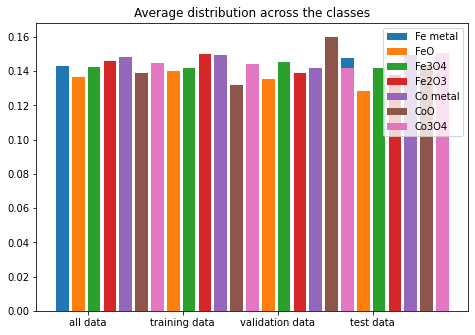

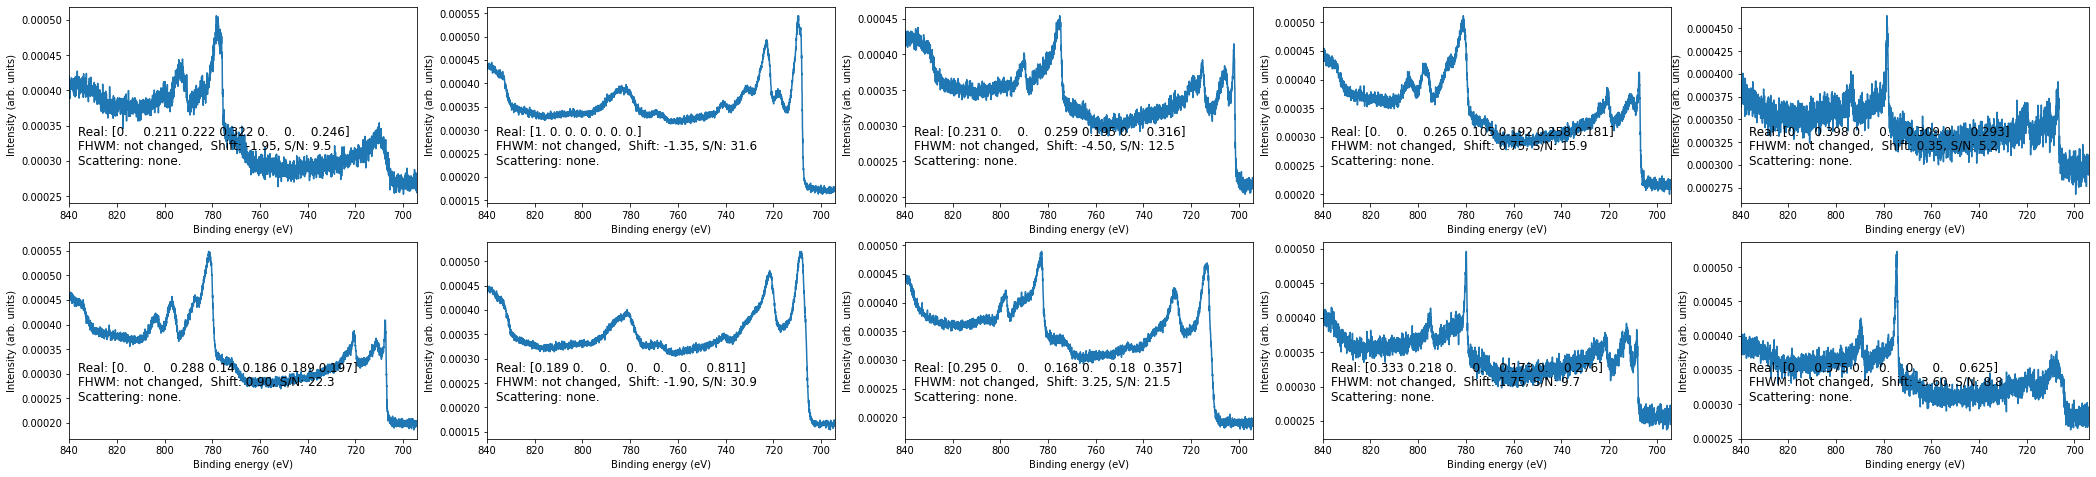

In [ ]:
input_filepath = r'/content/drive/My Drive/deepxps/datasets/20210903_CoFe_combined_without_auger_peaks.h5'

train_test_split = 0.2
train_val_split = 0.2
no_of_examples = 2000 #50000

X_train, X_val, X_test, y_train, y_val, y_test,\
    aug_values_train, aug_values_val, aug_values_test =\
        clf.load_data_preprocess(input_filepath = input_filepath,
                                 no_of_examples = no_of_examples,
                                 train_test_split = train_test_split,
                                 train_val_split = train_val_split)
               
# Check how the examples are distributed across the classes.
class_distribution = clf.datahandler.check_class_distribution(clf.task)
clf.plot_class_distribution()
clf.plot_random(no_of_spectra = 10, dataset = 'train')  

### Design the model

In [ ]:
try:
    importlib.reload(models)
    print('Models module was reloaded.')
except:
    import xpsdeeplearning.network.models as models
    print('Models module was loaded.')

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.python.keras import backend as K

class RegressionCNN(models.EmptyModel):
    """
    A CNN with three convolutional layers of different kernel size at 
    the beginning. Works well for learning across scales.
    
    This is to be used for regression on all labels. -> sigmoid 
    activation in the last layer.
    """
    def __init__(self, inputshape, num_classes):      
        self.input_1 = layers.Input(shape = inputshape)
                
        self.conv_1_short = layers.Conv1D(
            filters=12,
            kernel_size=5,
            strides=1,
            padding='same',
            activation='relu',
            name='conv_1_short')(self.input_1)
        self.conv_1_medium = layers.Conv1D(
            filters=12,
            kernel_size=10,
            strides=1,
            padding='same',
            activation='relu',
            name='conv_1_medium')(self.input_1)
        self.conv_1_long = layers.Conv1D(
            filters=12,
            kernel_size=15,
            strides=1,
            padding='same',
            activation='relu',
            name='conv_1_long')(self.input_1)
        
        sublayers = [self.conv_1_short, self.conv_1_medium, self.conv_1_long]
        merged_sublayers = layers.concatenate(sublayers)

        self.conv_2 = layers.Conv1D(
            filters=10,
            kernel_size=5,
            strides=1,
            padding='valid',
            activation='relu',
            name='conv_2')(merged_sublayers)
        self.conv_3 = layers.Conv1D(
            filters=10,
            kernel_size=5,
            strides=1,
            padding='valid',
            activation='relu',
            name="conv_3")(self.conv_2)
        self.average_pool_1 = layers.AveragePooling1D(
            name='average_pool_1')(self.conv_3)
        
        self.flatten_1 = layers.Flatten(name='flatten1')(self.average_pool_1)
        self.drop_1 = layers.Dropout(
            rate=0.2,
            name='drop_1')(self.flatten_1)
        self.dense_1 = layers.Dense(
            units=4000,
            activation='relu',
             name='dense_1')(self.drop_1)
        self.dense_2 = layers.Dense(
            units=num_classes,
            activation='sigmoid',
            name='dense_2')(self.dense_1)
        
        self.output_norm = layers.Lambda(
            lambda x: x/tf.reshape(K.sum(x, axis=-1),(-1,1)),
            name = 'output_normalization')(self.dense_2)

        no_of_inputs = len(sublayers)

        super(RegressionCNN, self).__init__(inputs=self.input_1,
                                            outputs=self.output_norm,
                                            inputshape=inputshape,
                                            num_classes=num_classes,
                                            no_of_inputs=no_of_inputs,
                                            name='RegressionCNN')

Models module was loaded.


#### Build the model

In [ ]:
clf.model = RegressionCNN(clf.datahandler.input_shape,
                          clf.datahandler.num_classes)

# =============================================================================
# clf.model = ResNet1D(clf.datahandler.input_shape,
#                      clf.datahandler.num_classess,
#                      ap=True)
# =============================================================================

# Alternative: Build model from available models in models.py
# =============================================================================
# clf.model = models.RegressionCNN(clf.datahandler.input_shape, 
#                                  clf.datahandler.num_classes)
# =============================================================================
# =============================================================================
# clf.model = models.ResNet1D(clf.datahandler.input_shape,
#                             clf.datahandler.num_classes,
#                             ap=True)
# =============================================================================
# =============================================================================
# clf.model = models.ResNet1D(clf.datahandler.input_shape,
#                             clf.datahandler.num_classes,
#                             ap=True)
# =============================================================================

### Compile and summarize the model

Model: "RegressionCNN"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 2921, 1)]    0           []                               
                                                                                                  
 conv_1_short (Conv1D)          (None, 2921, 12)     72          ['input_1[0][0]']                
                                                                                                  
 conv_1_medium (Conv1D)         (None, 2921, 12)     132         ['input_1[0][0]']                
                                                                                                  
 conv_1_long (Conv1D)           (None, 2921, 12)     192         ['input_1[0][0]']                
                                                                                      

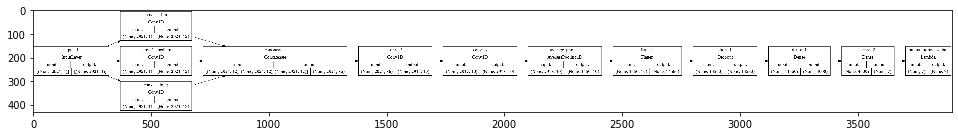

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanAbsoluteError, MeanSquaredError
from tensorflow.keras.losses import CategoricalCrossentropy

learning_rate = 1e-05
optimizer = Adam(learning_rate = learning_rate) 

if clf.task == 'regression':
    mae = MeanAbsoluteError()
    clf.model.compile(loss = mae,
                      optimizer = optimizer,
                      metrics=["mse"])
    # =============================================================================
    # mse = MeanSquaredError()
    # clf.model.compile(loss = mse, 
    #                   optimizer = optimizer,
    #                   metrics=["mae"])
    # =============================================================================
    
elif clf.task == 'classification':
    categorical_crossentropy = CategoricalCrossentropy()
    clf.model.compile(loss = categorical_crossentropy,
                      optimizer = optimizer,
                      metrics = ['accuracy'])

# Plot summary and save model plot.
clf.summary()
clf.save_and_print_model_image()

### Show initial predictions

In [ ]:
pred_train_initial, pred_test_initial = clf.predict()

print('Train:')
for i in range(5):
    print('real: ' + str(np.round(y_train[i],3)),
          'pred: ' + str(pred_train_initial[i]))
print('Test:')
for i in range(5):
    print('real: ' + str(np.round(y_test[i],3)),
          'pred: ' + str(pred_test_initial[i]))

13/13 [==============================] - 0s 13ms/step
Prediction done!
Train:
real: [0.    0.    0.    0.304 0.696 0.    0.   ] pred: [0.14285994 0.14285241 0.14285697 0.1428549  0.14286062 0.14285548
 0.14285965]
real: [0. 0. 0. 0. 1. 0. 0.] pred: [0.14286058 0.14285134 0.14285614 0.14285424 0.14286058 0.14285694
 0.14286019]
real: [0.413 0.405 0.    0.    0.    0.182 0.   ] pred: [0.14285882 0.14285274 0.1428562  0.14285505 0.14286084 0.1428557
 0.14286065]
real: [0.142 0.324 0.    0.145 0.389 0.    0.   ] pred: [0.14286068 0.14285229 0.14285655 0.14285475 0.14286135 0.14285451
 0.14285989]
real: [0.    0.    0.    0.468 0.372 0.    0.161] pred: [0.14285992 0.14285287 0.14285555 0.14285484 0.1428608  0.14285566
 0.14286037]
Test:
real: [0.    0.378 0.    0.236 0.    0.    0.386] pred: [0.14285904 0.14285378 0.14285569 0.14285517 0.14286073 0.14285418
 0.14286144]
real: [0.   0.   0.28 0.   0.72 0.   0.  ] pred: [0.1428593  0.14285286 0.14285685 0.1428553  0.14286186 0.14285506
 0.142

### Train

In [ ]:
epochs = 10 #00
batch_size = 32

hist = clf.train(checkpoint = True,
                 early_stopping = False,
                 tb_log = True, 
                 csv_log = True,
                 hyperparam_log = True,
                 epochs = epochs, 
                 batch_size = batch_size,
                 verbose = 1)

sound = False
if sound:
    from google.colab import output
    output.eval_js('new Audio("http://soundbible.com/grab.php?id=1795&type=mp3").play()')

Epoch 1/10
39/40 [============================>.] - ETA: 0s - loss: 0.1503 - mse: 0.0394INFO:tensorflow:Assets written to: /content/drive/My Drive/deepxps/runs/20211213_14h00m_FeCo_combined_without_auger_7_classes_no_window/model/assets


### Plot loss

In [ ]:
graph = clfutils.TrainingGraphs(clf.logging.history, clf.logging.fig_dir)
graph.plot_loss(to_file = True)
if clf.task == 'classification':
    graph.plot_accuracy(to_file = False)

### Evaluate on test data

In [ ]:
if clf.task == 'classification':
    score = clf.evaluate()
    test_loss, test_accuracy = score[0], score[1]
    print('Test loss: ' + str(np.round(test_loss, decimals=8)))
    print('Test accuracy: ' + str(np.round(test_accuracy, decimals=3)))
elif clf.task == 'regression':
    test_loss = clf.evaluate()
    print('Test loss: ' + str(np.round(test_loss, decimals=8)))

###  Predict on train and test data

In [ ]:
pred_train, pred_test = clf.predict()
if clf.task == 'classification':
    pred_train_classes, pred_test_classes = clf.predict_classes()

print('Train:')
for i in range(5):
    print('real: ' + str(np.round(y_train[i],3)),
          'pred: ' + str(pred_train[i]))
print('Test:')
for i in range(5):
    print('real: ' + str(np.round(y_test[i],3)),
          'pred: ' + str(pred_test[i]))

### Show some predictions

#### 10 random training samples

In [ ]:
clf.plot_random(no_of_spectra = 10, dataset = 'train', with_prediction = True)  

#### 10 random test samples

In [ ]:
clf.plot_random(no_of_spectra = 10, dataset = 'test', with_prediction = True)  

### Show wrong/worst predictions

In [ ]:
if clf.task == 'classification':
    clf.show_wrong_classification()
elif clf.task == 'regression':
    clf.show_worst_predictions(no_of_spectra = 20)  

### Save model and results

In [ ]:
#clf.save_model()
clf.pickle_results()

### Generate report

In [ ]:
dir_name = clf.time + '_' + clf.exp_name
rep = clfutils.Report(dir_name)  
rep.write()

## Continue training

### Load custom modules

In [ ]:
try:
    import importlib
    importlib.reload(classifier)
    importlib.reload(clfutils)
    print('\n Modules were reloaded.')
except:
    import xpsdeeplearning.network.classifier as classifier
    import xpsdeeplearning.network.utils as clfutils
    print('\n Modules were loaded.')

### Reload classifier from previous run

In [ ]:
runpath = r'/content/drive/My Drive/deepxps/runs/20210914_19h11m_FeCo_combined_without_auger_7_classes_no_window'
clf = classifier.restore_clf_from_logs(runpath)

### Load and inspect the data

In [ ]:
X_train, X_val, X_test, y_train, y_val, y_test,\
    aug_values_train, aug_values_val, aug_values_test =\
        clf.load_data_preprocess(
            input_filepath = clf.logging.hyperparams['input_filepath'],
            no_of_examples = clf.logging.hyperparams['no_of_examples'],
            train_test_split = clf.logging.hyperparams['train_test_split'],
            train_val_split = clf.logging.hyperparams['train_val_split'])
                
# Check how the examples are distributed across the classes.
class_distribution = clf.datahandler.check_class_distribution(clf.task)
clf.plot_class_distribution()
clf.plot_random(no_of_spectra = 10, dataset = 'train')  

### Load the model

In [ ]:
clf.load_model(compile_model = True)

### Summarize the model

In [ ]:
# Plot summary and save model plot.
clf.summary()
clf.save_and_print_model_image()

### Show predictions with current model

In [ ]:
pred_train_intermediate, pred_test_intermediate = clf.predict()

print('Train:')
for i in range(5):
    print('real: ' + str(np.round(y_train[i],3)),
          'pred: ' + str(pred_train_intermediate[i]))
print('Test:')
for i in range(5):
    print('real: ' + str(np.round(y_test[i],3)),
          'pred: ' + str(pred_test_intermediate[i]))
    
clf.plot_random(no_of_spectra=10, dataset='test', with_prediction=True)

### Train

In [ ]:
epochs = 1000

#new_learning_rate = 1e-05#5e-06

hist = clf.train(checkpoint = True,
                 early_stopping = False,
                 tb_log = True, 
                 csv_log = True,
                 hyperparam_log = True,
                 epochs = epochs, 
                 batch_size = clf.logging.hyperparams['batch_size'],
                 verbose = 1,)
#                 new_learning_rate = new_learning_rate)

### Show predictions with current model

In [ ]:
pred_train_intermediate, pred_test_intermediate = clf.predict()

print('Train:')
for i in range(5):
    print('real: ' + str(np.round(y_train[i],3)),
          'pred: ' + str(pred_train_intermediate[i]))
print('Test:')
for i in range(5):
    print('real: ' + str(np.round(y_test[i],3)),
          'pred: ' + str(pred_test_intermediate[i]))
    
clf.plot_random(no_of_spectra=10, dataset='test', with_prediction=True)

### Train

In [ ]:
epochs = 1000

#new_learning_rate = 1e-05#5e-06

hist = clf.train(checkpoint = True,
                 early_stopping = False,
                 tb_log = True, 
                 csv_log = True,
                 hyperparam_log = True,
                 epochs = epochs, 
                 batch_size = clf.logging.hyperparams['batch_size'],
                 verbose = 1,)
#                 new_learning_rate = new_learning_rate)

### Plot loss

In [ ]:
graph = clfutils.TrainingGraphs(clf.logging.history, clf.logging.fig_dir)
graph.plot_loss(to_file = True)
if clf.task == 'classification':
    graph.plot_accuracy(to_file = True)

### Evaluate on test data

In [ ]:
if clf.task == 'classification':
    score = clf.evaluate()
    test_loss, test_accuracy = score[0], score[1]
    print('Test loss: ' + str(np.round(test_loss, decimals=8)))
    print('Test accuracy: ' + str(np.round(test_accuracy, decimals=3)))
elif clf.task == 'regression':
    test_loss = clf.evaluate()
    print('Test loss: ' + str(np.round(test_loss, decimals=8)))

###  Predict on train and test data

In [ ]:
pred_train, pred_test = clf.predict()
if clf.task == 'classification':
    pred_train_classes, pred_test_classes = clf.predict_classes()

### Show some predictions

#### 10 random training samples

In [ ]:
clf.plot_random(no_of_spectra = 10, dataset = 'train', with_prediction = True)  

#### 10 random test samples

In [ ]:
clf.plot_random(no_of_spectra = 10, dataset = 'test', with_prediction = True)  

### Show wrong/worst predictions

In [ ]:
if clf.task == 'classification':
    clf.show_wrong_classification()
elif clf.task == 'regression':
    clf.show_worst_predictions(no_of_spectra = 20)  

### Save model and data

In [ ]:
#clf.save_model()
clf.pickle_results()

### Generate report

In [ ]:
dir_name = clf.time + '_' + clf.exp_name
rep = clfutils.Report(dir_name)  
rep.write()

## Prepare website upload

In [ ]:
from xpsdeeplearning.network.prepare_upload import Uploader

dataset_path = clf.logging.hyperparams["input_filepath"].rsplit(".",1)[0] + "_metadata.json"
uploader = Uploader(clf.logging.root_dir, dataset_path)
uploader.prepare_upload_params()
uploader.save_upload_params()

## Save output of notebook

In [ ]:
from IPython.display import Javascript, display
from nbconvert import HTMLExporter

def save_notebook():
    display(Javascript("IPython.notebook.save_notebook()"),
            include=['application/javascript'])

def output_HTML(read_file, output_file):
    import codecs
    import nbformat
    exporter = HTMLExporter()
    # read_file is '.ipynb', output_file is '.html'
    output_notebook = nbformat.read(read_file, as_version=4)
    output, resources = exporter.from_notebook_node(output_notebook)
    codecs.open(output_file, 'w', encoding='utf-8').write(output)

import time
import os

time.sleep(20)
save_notebook()
print('Notebook saved!')
time.sleep(30)
current_file = '/content/drive/My Drive/deepxps/xpsdeeplearning/train.ipynb'
output_file = os.path.join(clf.logging.log_dir,'train_out.html')
output_HTML(current_file, output_file)
print('HTML file saved!')